In [1]:
import matplotlib.pyplot as plt
from datasets import FlickrDataset
import numpy as np
import torch
import torchvision.transforms.functional as TF
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm
from models import ResNet34
from models import SiameseNetwork
import random
from distances import *
#from datasets import SketchQueryDataset
from datasets import TripletDataset
from datasets import ContrastiveDataset
import cv2
from torch.utils.data import DataLoader
from feats import ImageFlickrFeatures
from torchvision.transforms import transforms
from ranking import Ranker

from os import listdir

from eval import Evaluator
from metrics import *

In [2]:
test_flickr_db = FlickrDataset('B:\Flickr\Flickr15K\images')
#test_flickr_loader = DataLoader(test_flickr_db, batch_size=8)

[FLICKR] 33 classes with a total of 14501 samples


In [3]:
img_per_class = test_flickr_db._build_groups()

[FLICKR] 33 classes with a total of 14501 samples


In [4]:
img_per_class = test_flickr_db._build_groups()
len_classes = []
for i in range(1,34):
    len_classes.append(len(img_per_class[str(i)]))

[FLICKR] 33 classes with a total of 14501 samples


In [6]:
len_classes[0]

1305

In [34]:
cpi = test_flickr_db._build_groups()

[FLICKR] 33 classes with a total of 14501 samples


In [5]:
imagenet_net = ResNet34()
sketches_net = ResNet34()

print("Adapting output layers...")
sketches_net.adapt_fc()
imagenet_net.adapt_fc()

siamese_net = SiameseNetwork(sketches_net, imagenet_net)
siamese_net.load_state_dict(torch.load(r'C:\Users\aleja\Desktop\Tareas\Reconocimiento Virtual con Deep Learning\T2\best_SiameseNetwork_contrastive.pth'))
siamese_net.eval()

s = torch.nn.CosineSimilarity()
flickr_dataset = ImageFlickrFeatures("dbs/features.db")
r = Ranker('B:\Flickr\Flickr15K',
           image_dataset_features=flickr_dataset,
           feature_extractor=siamese_net,
           similarity_fn=s)
#rank = r.get_rank(r'B:\Flickr\Flickr15K\queries\1001.png')

Adapting output layers...
14501 images loaded successfully


In [42]:
x,y = recall_ratio(r,r'B:\Flickr\Flickr15K\queries\1001.png',len_classes[0])

Querying: 100%|██████████████████████████████████████████████████████████████████| 1813/1813 [00:00<00:00, 3888.56it/s]


Text(0.5, 1.0, 'Recall ratio Curve')

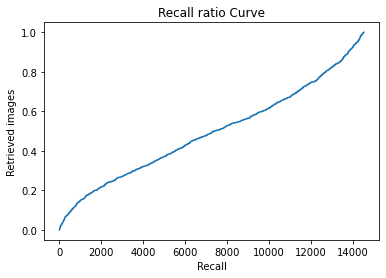

In [43]:
plt.plot(x,y)
plt.xlabel('Recall')
plt.ylabel('Retrieved images')
plt.title('Recall ratio Curve')

In [9]:
len(rank[1])

14501

In [44]:
ap = average_precision(r,r'B:\Flickr\Flickr15K\queries\1001.png')

Querying: 100%|██████████████████████████████████████████████████████████████████| 1813/1813 [00:00<00:00, 3722.25it/s]


In [45]:
ap

0.12750345488090062

In [6]:
imgs_names = listdir(r'B:\Flickr\Flickr15K\queries')

In [7]:
imgs_names = listdir(r'B:\Flickr\Flickr15K\queries')
for i in range(len(imgs_names)):
    imgs_names[i] = r'B:/Flickr/Flickr15K/queries/' + imgs_names[i]

In [7]:
imgs_names[0]

'B:/Flickr/Flickr15K/queries/10001.png'

In [30]:
mean_ap

0.03297857655856321

In [51]:
rps[0]

array([1.        , 0.25359712, 0.15508021, 0.11218679, 0.09577982,
       0.08531451, 0.08052242, 0.08170473, 0.08556851, 0.0900988 ,
       0.09007454])

In [44]:
def recall_prec_tot(r, path_list):
    test_flickr_db = FlickrDataset('B:\Flickr\Flickr15K\images')
    img_per_class = test_flickr_db._build_groups()
    len_classes = []
    for i in range(1,34):
        len_classes.append(len(img_per_class[str(i)]))
    ranks= []
    cs =[]
    for j in range(len(path_list)):
        c,rank = r.get_rank(path_list[j])
        cs.append(c)
        ranks.append(rank)
    rps = []
    for i in range(len(path_list)):
        rp = recall_presicion2(cs[i],ranks[i],len_classes[cs[i]-1])
        print(cs[i]-1)
        rps.append(rp)
    return rps
    

In [ ]:
rps = recall_prec_tot(r,imgs_names)

In [21]:
pplot = np.mean(rps, 0)

Text(0.5, 1.0, 'Recall-Precision Curve')

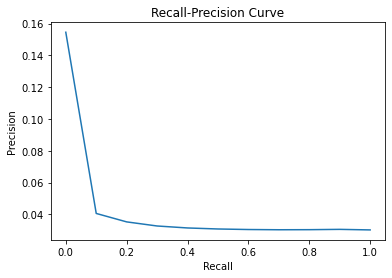

In [22]:
plt.plot(recalls,pplot)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Recall-Precision Curve')

In [29]:
rps[0]

array([1.        , 0.25359712, 0.15508021, 0.11218679, 0.09577982,
       0.08531451, 0.08052242, 0.08170473, 0.08556851, 0.0900988 ,
       0.09007454])

In [31]:
imgs_names[0]

'B:/Flickr/Flickr15K/queries/10001.png'

In [27]:
rp = recall_presicion(r,r'B:\Flickr\Flickr15K\queries\1001.png',len_classes[0])

Querying: 100%|██████████████████████████████████████████████████████████████████| 1813/1813 [00:00<00:00, 3647.95it/s]


In [28]:
rp

array([0.75      , 0.22596965, 0.15498812, 0.10945274, 0.09507487,
       0.08863852, 0.08119038, 0.08232407, 0.08529668, 0.08998689,
       0.09003726])

Text(0.5, 1.0, 'Recall-Precision Curve')

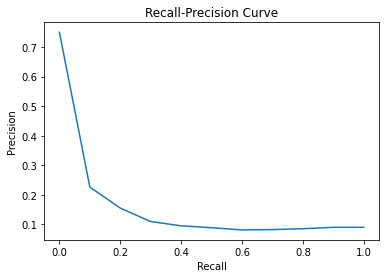

In [11]:
plt.plot(recalls,rp)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Recall-Precision Curve')

In [ ]:
rank1 = r.get_rank()

In [44]:
prec = np.zeros(11)
cont = 0
cont2 = 0

for i in range(len(rank[1])):
    if rank[1][i][1] == 1:
        cont = (1+ cont2)/(i+1)
        cont2 += 1
        idx = int((cont2/len_classes[0])*10)
        if cont > prec[idx]:
            prec[idx] = cont
            
        

In [45]:
prec

array([0.75      , 0.22596965, 0.15498812, 0.10945274, 0.09507487,
       0.08863852, 0.08119038, 0.08232407, 0.08529668, 0.08998689,
       0.09003726])

In [20]:
recalls = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

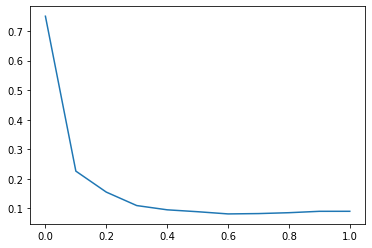

In [49]:
plt.plot(recalls,prec,'-')

In [29]:
rank1 = r.get_rank(imgs_names[7])

Querying: 100%|██████████████████████████████████████████████████████████████████| 1813/1813 [00:00<00:00, 3666.04it/s]


In [2]:
pw = r'C:\Users\aleja\Desktop\Tareas\Reconocimiento Virtual con Deep Learning\T2\best_SiameseNetwork_contrastive.pth'
pd = 'B:\Flickr\Flickr15K'
l_c = 'B:\Flickr\Flickr15K\images'
sim = torch.nn.CosineSimilarity()
a = Evaluator(pw,pd,sim)

14501 images loaded successfully


In [3]:
pq = r'B:\Flickr\Flickr15K\queries'
a.calc_all_ranks(pq)

Querying: 100%|██████████████████████████████████████████████████████████████████| 1813/1813 [00:00<00:00, 3425.72it/s]


In [4]:
mapita = a.calc_map()
mapita

0.03297857655856321

[FLICKR] 33 classes with a total of 14501 samples
[FLICKR] 33 classes with a total of 14501 samples


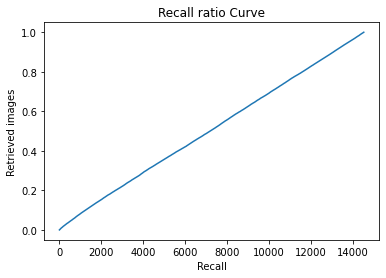

In [6]:
x,y = a.calc_recall_ratio(l_c)

[FLICKR] 33 classes with a total of 14501 samples
[FLICKR] 33 classes with a total of 14501 samples


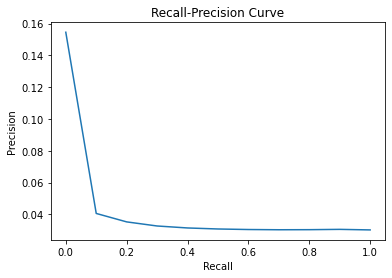

In [7]:
rp = a.calc_recall_prec(l_c)

[FLICKR] 33 classes with a total of 14501 samples
[FLICKR] 33 classes with a total of 14501 samples


array([0.15540188, 0.04156103, 0.03603674, 0.03324334, 0.0319077 ,
       0.03129775, 0.03104536, 0.03082109, 0.03067369, 0.03055323,
       0.03019482])

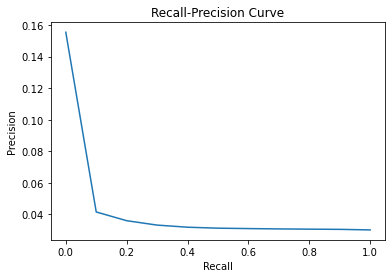

In [5]:
rp = a.calc_recall_prec(l_c)
rp

In [8]:
rp

array([0.15455729, 0.04055576, 0.03524553, 0.03266611, 0.03142474,
       0.03078124, 0.03044442, 0.03029653, 0.03034701, 0.0305433 ,
       0.03019482])

In [ ]:
pqg = r'B:\Flickr\Flickr15K\queries'
mapita = a.calc_map(pqg)

In [11]:
mapita

0.03297857655856321

In [8]:
classes = []
ranks = []
for i in range(len(imgs_names)):
    c,rank = r.get_rank(imgs_names[i])
    classes.append(c)
    ranks.append(rank)

Querying: 100%|██████████████████████████████████████████████████████████████████| 1813/1813 [00:00<00:00, 3307.91it/s]


In [9]:
map(classes, ranks)

0.03297857655856321

In [10]:
rr = recall_ratio_tot(classes, ranks,'B:\Flickr\Flickr15K\images')

[FLICKR] 33 classes with a total of 14501 samples
[FLICKR] 33 classes with a total of 14501 samples


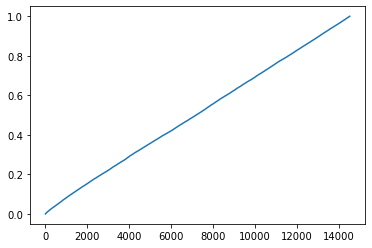

In [11]:
plt.plot(rr[0],rr[1])

In [12]:
recall_prec_tot(classes, ranks,'B:\Flickr\Flickr15K\images')

[FLICKR] 33 classes with a total of 14501 samples
[FLICKR] 33 classes with a total of 14501 samples


array([0.15455729, 0.04055576, 0.03524553, 0.03266611, 0.03142474,
       0.03078124, 0.03044442, 0.03029653, 0.03034701, 0.0305433 ,
       0.03019482])

In [13]:
1+1

2